# Task 1 : Set up colab gpu runtime environment

In [ ]:
!pip install segmentation-models-pytorch
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install --upgrade opencv-contrib-python

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 KB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 KB 3.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 549.1/549.1 KB 26.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 26.3 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16446 sha256=331cce3a912f1f096ea14138805dee00358c16dd1c38c5a07f8b9f93ad5bf1f1
  Stored in directory: /root/.cache/pip/wheels/84/b9/90/25a0195cf95fb5533db96f1c77ea3f296b7cc86ae8ae48e3dc
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60966 sha256=9d06f47478db31e5ca1952f1713a1ad2c6201982f4ae35ea32d1036b55da5792
  Stored in directory: /root/.cache/pip/w

# Download Dataset

original author of the dataset :
https://github.com/VikramShenoy97/Human-Segmentation-Dataset


In [ ]:
!git clone https://github.com/parth1620/Human-Segmentation-Dataset-master.git

Cloning into 'Human-Segmentation-Dataset-master'...
remote: Enumerating objects: 592, done.
remote: Counting objects: 100% (592/592), done.
remote: Compressing objects: 100% (591/591), done.
remote: Total 592 (delta 3), reused 587 (delta 1), pack-reused 0
Receiving objects: 100% (592/592), 13.60 MiB | 7.10 MiB/s, done.
Resolving deltas: 100% (3/3), done.


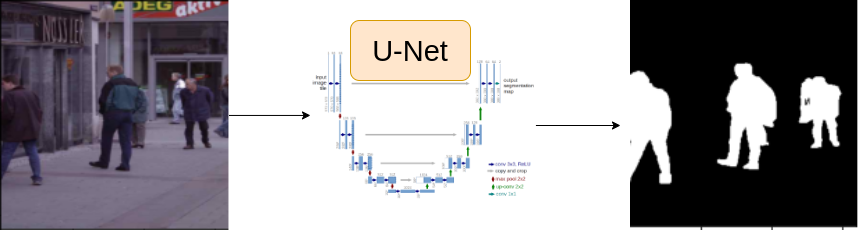

# Some Common Imports

In [ ]:
import sys
sys.path.append('/content/Human-Segmentation-Dataset-master')

In [ ]:
import torch 
import cv2

import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 

from sklearn.model_selection import train_test_split
from tqdm import tqdm

import helper

# Task : 2 Setup Configurations

In [ ]:
CSV_FILE = '/content/Human-Segmentation-Dataset-master/train.csv'
DATA_DIR = '/content/'

DEVICE = 'cuda'

EPOCHS = 25
LR = 0.003
IMAGE_SIZE = 320
BATCH_SIZE = 16

ENCODER = 'timm-efficientnet-b0'
WEIGHTS = 'imagenet'

In [ ]:
df = pd.read_csv(CSV_FILE)
df.head()

,masks,images
0,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
1,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
2,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
3,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
4,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...


In [ ]:
row = df.iloc[1]
image_path, mask_path = row.images, row.masks

In [ ]:
image = cv2.imread("Human-Segmentation-Dataset-master/Training_Images/112.jpg")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
mask = cv2.imread("Human-Segmentation-Dataset-master/Ground_Truth/112.png", cv2.IMREAD_GRAYSCALE) / 255.0

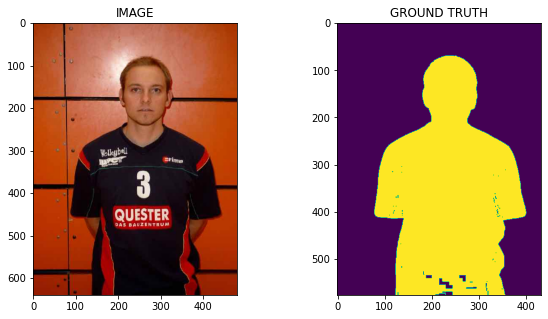

In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
        
ax1.set_title('IMAGE')
ax1.imshow(image)

ax2.set_title('GROUND TRUTH')
ax2.imshow(mask)

In [ ]:
train_df, valid_df = train_test_split(df, test_size=0.2, random_state = 42)

In [ ]:
image.shape

(640, 480, 3)

In [ ]:
print(image.shape)
np.expand_dims(mask, axis = -1).shape

(640, 480, 3)


(577, 433, 1)

# Task 3 : Augmentation Functions

albumentation documentation : https://albumentations.ai/docs/

In [ ]:
import albumentations as A

In [ ]:
def get_train_augs():
  return A.Compose([
      A.Resize(IMAGE_SIZE, IMAGE_SIZE),
      A.HorizontalFlip(p = 0.5),
      A.VerticalFlip(p = 0.5),
  ],)

def get_val_augs():
  return A.Compose([
      A.Resize(IMAGE_SIZE, IMAGE_SIZE)
  ])

# Task 4 : Create Custom Dataset 

In [ ]:
from torch.utils.data import Dataset

In [ ]:
class SegmentationDataset(Dataset):

  def __init__(self, df, augmentations):

    self.df = df
    self.augmentations = augmentations

  def __len__(self):
    return len(self.df)
  
  def __getitem__(self, idx):
    
    row = self.df.iloc[idx]
    image_path = row.images
    mask_path = row.masks

    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

    mask = cv2.resize(mask, (image.shape[1], image.shape[0]))

    if self.augmentations:
      data = self.augmentations(image = image, mask = mask)
      image = data["image"]
      mask = data["mask"]
    
    mask = np.expand_dims(mask, axis = -1)

    print(mask.shape, image.shape)
    image = np.transpose(image, (2,0,1)).astype(np.float32)
    mask = np.transpose(mask, (2,0,1)).astype(np.float32)
    print(mask.shape, image.shape)
    image = torch.Tensor(image) / 255.0
    mask = torch.round(torch.Tensor(mask) / 255.0)

    return image, mask

In [ ]:
trainset = SegmentationDataset(train_df, get_train_augs())
validset = SegmentationDataset(valid_df, get_val_augs())

In [ ]:
print(f"Size of Trainset : {len(trainset)}")
print(f"Size of Validset : {len(validset)}")

Size of Trainset : 232
Size of Validset : 58


(320, 320, 1) (320, 320, 3)
(1, 320, 320) (3, 320, 320)


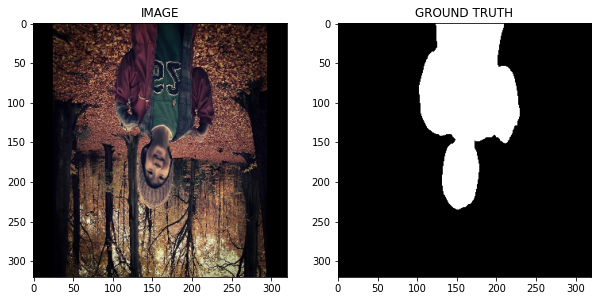

In [ ]:
idx = 21

image, mask = trainset[idx]
helper.show_image(image, mask)

# Task 5 : Load dataset into batches

In [ ]:
from torch.utils.data import DataLoader

In [ ]:
trainloader = DataLoader(trainset, batch_size = BATCH_SIZE, shuffle = True)
validloader = DataLoader(validset, batch_size = BATCH_SIZE, shuffle = True)

In [ ]:
print(f"total no. of batches in trainloader: {len(trainloader)}")
print(f"total no. of batches in validloader: {len(validloader)}")

total no. of batches in trainloader: 15
total no. of batches in validloader: 4


In [ ]:
for image, mask in trainloader:
  break

print(f"1 batch shape in train: {image.shape}")
print(f"1 batch shape in train: {mask.shape}")

1 batch shape in train: torch.Size([16, 3, 320, 320])
1 batch shape in train: torch.Size([16, 1, 320, 320])


# Task 6 : Create Segmentation Model

segmentation_models_pytorch documentation : https://smp.readthedocs.io/en/latest/

In [ ]:
!pip install segmentation_models_pytorch

In [ ]:
import torch.nn as nn
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss

In [ ]:
class SegmentationModel(nn.Module):

  def __init__(self):
    super(SegmentationModel, self).__init__()

    self.arc = smp.Unet(
        encoder_name = ENCODER,
        encoder_weights=WEIGHTS,
        in_channels = 3,
        classes = 1,
        activation = None
    )

  def forward(self, images, masks = None):

    logits = self.arc(images)

    if masks != None:
      loss1 = DiceLoss(mode = 'binary')(logits, masks)
      loss2 = nn.BCEWithLogitsLoss()(logits, masks)
      
      return logits, loss1 + loss2
    
    return logits

In [ ]:
model = SegmentationModel()
model.to(DEVICE)

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/tf_efficientnet_b0_aa-827b6e33.pth" to /root/.cache/torch/hub/checkpoints/tf_efficientnet_b0_aa-827b6e33.pth


  0%|          | 0.00/20.4M [00:00<?, ?B/s]

SegmentationModel(
  (arc): Unet(
    (encoder): EfficientNetEncoder(
      (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn1): BatchNormAct2d(
        32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
        (drop): Identity()
        (act): Swish()
      )
      (blocks): Sequential(
        (0): Sequential(
          (0): DepthwiseSeparableConv(
            (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (bn1): BatchNormAct2d(
              32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
              (drop): Identity()
              (act): Swish()
            )
            (se): SqueezeExcite(
              (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
              (act1): Swish()
              (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
              (gate): Sigmoid()
            )
           

# Task 7 : Create Train and Validation Function 

In [ ]:
def train_fn(data_loader, model, optimizer):

  model.train()

  total_loss = 0.0

  for images, masks in tqdm(data_loader):

    images = images.to(DEVICE)
    masks = masks.to(DEVICE)

    optimizer.zero_grad()
    logits, loss = model(images, masks)
    loss.backward()
    optimizer.step()

    total_loss += loss.item()
  
  return total_loss / len(data_loader)

In [ ]:
def eval_fn(data_loader, model):

  model.eval()
  total_loss = 0.0

  with torch.no_grad():
    for images, masks in tqdm(data_loader):
      images = images.to(DEVICE)
      masks = masks.to(DEVICE)

      logits, loss = model(images, masks)

      total_loss += loss.item()
    
  return total_loss / len(data_loader)

# Task 8 : Train Model

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr = LR)

In [ ]:
best_val_loss = np.Inf

for i in range(EPOCHS):
  
  train_loss = train_fn(trainloader, model, optimizer)
  val_loss = eval_fn(validloader, model)

  if val_loss < best_val_loss:
    torch.save(model.state_dict(), 'best_model_pt')
    print("Saved Model")
    best_val_loss = val_loss

  print(f"Epoch : {i+1} Train loss: {train_loss} Valid loss: {val_loss}")

100%|██████████| 4/4 [00:00<00:00,  5.24it/s]


Saved Model
Epoch : 1 Train loss: 0.8021016637484233 Valid loss: 1.3806356191635132


100%|██████████| 4/4 [00:00<00:00,  5.10it/s]


Saved Model
Epoch : 2 Train loss: 0.39169331987698874 Valid loss: 0.307442057877779


100%|██████████| 4/4 [00:00<00:00,  5.17it/s]


Saved Model
Epoch : 3 Train loss: 0.36293154060840604 Valid loss: 0.252747755497694


100%|██████████| 4/4 [00:00<00:00,  5.29it/s]


Epoch : 4 Train loss: 0.2886147767305374 Valid loss: 0.27189527079463005


100%|██████████| 4/4 [00:00<00:00,  5.08it/s]


Epoch : 5 Train loss: 0.2938675324122111 Valid loss: 0.2600516974925995


100%|██████████| 4/4 [00:00<00:00,  5.16it/s]


Saved Model
Epoch : 6 Train loss: 0.28000494043032326 Valid loss: 0.2445056363940239


100%|██████████| 4/4 [00:00<00:00,  5.23it/s]


Epoch : 7 Train loss: 0.25514252881209054 Valid loss: 0.27585436776280403


100%|██████████| 4/4 [00:00<00:00,  4.93it/s]


Saved Model
Epoch : 8 Train loss: 0.18620055715243022 Valid loss: 0.19899876788258553


100%|██████████| 4/4 [00:00<00:00,  5.17it/s]


Epoch : 9 Train loss: 0.17215244819720585 Valid loss: 0.2259649820625782


100%|██████████| 4/4 [00:00<00:00,  5.21it/s]


Saved Model
Epoch : 10 Train loss: 0.16143646836280823 Valid loss: 0.17286983504891396


100%|██████████| 4/4 [00:00<00:00,  5.13it/s]


Epoch : 11 Train loss: 0.14713977972666423 Valid loss: 0.23098565265536308


100%|██████████| 4/4 [00:00<00:00,  5.00it/s]


Epoch : 12 Train loss: 0.16223042209943137 Valid loss: 0.20373407006263733


100%|██████████| 4/4 [00:00<00:00,  5.24it/s]


Epoch : 13 Train loss: 0.13322177131970722 Valid loss: 0.22591528668999672


100%|██████████| 4/4 [00:00<00:00,  5.31it/s]


Epoch : 14 Train loss: 0.14648245026667914 Valid loss: 0.1942170448601246


100%|██████████| 4/4 [00:00<00:00,  5.15it/s]


Epoch : 15 Train loss: 0.14295309036970139 Valid loss: 0.1991804763674736


100%|██████████| 4/4 [00:00<00:00,  5.05it/s]


Epoch : 16 Train loss: 0.13181254963080088 Valid loss: 0.21255635097622871


100%|██████████| 4/4 [00:00<00:00,  5.14it/s]


Epoch : 17 Train loss: 0.1243127703666687 Valid loss: 0.18699213862419128


100%|██████████| 4/4 [00:00<00:00,  5.17it/s]


Epoch : 18 Train loss: 0.10900754282871881 Valid loss: 0.1772449091076851


100%|██████████| 4/4 [00:00<00:00,  5.20it/s]


Epoch : 19 Train loss: 0.11723552097876867 Valid loss: 0.17544030025601387


100%|██████████| 4/4 [00:00<00:00,  5.24it/s]


Epoch : 20 Train loss: 0.10990450928608576 Valid loss: 0.22941625490784645


100%|██████████| 4/4 [00:00<00:00,  5.08it/s]


Epoch : 21 Train loss: 0.12399621506532034 Valid loss: 0.29298727214336395


100%|██████████| 4/4 [00:00<00:00,  5.19it/s]


Epoch : 22 Train loss: 0.12808321366707484 Valid loss: 0.1988201104104519


100%|██████████| 4/4 [00:00<00:00,  5.17it/s]


Epoch : 23 Train loss: 0.12144945214192072 Valid loss: 0.2748773731291294


100%|██████████| 4/4 [00:00<00:00,  5.22it/s]


Epoch : 24 Train loss: 0.1069547787308693 Valid loss: 0.2540532201528549


100%|██████████| 4/4 [00:00<00:00,  5.12it/s]

Epoch : 25 Train loss: 0.08972202986478806 Valid loss: 0.21491789817810059


# Task 9 : Inference

In [ ]:
idx = 20

model.load_state_dict(torch.load('/content/best_model.pt'))

image, mask = validset[idx]

logit_mask = model(image.to(DEVICE).unsqueeze(0))
pred_mask = torch.sigmoid(logit_mask)

pred_mask = (pred_mask > 0.5)*1.0

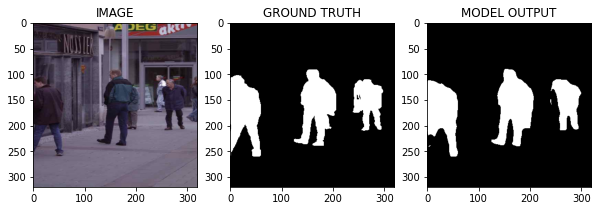

In [ ]:
helper.show_image(image, mask, pred_mask.detach().cpu().squeeze(0))